## Setup

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 10.1MB/s 
     |████████████████████████████████| 194kB 21.3MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 1.2MB 21.6MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 242kB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
from fastbook import *

## PETS Dataset

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [6]:
(path/'images').ls()

(#7393) [Path('images/saint_bernard_170.jpg'),Path('images/Abyssinian_22.jpg'),Path('images/Maine_Coon_71.jpg'),Path('images/newfoundland_137.jpg'),Path('images/havanese_128.jpg'),Path('images/Bengal_193.jpg'),Path('images/pomeranian_152.jpg'),Path('images/wheaten_terrier_32.jpg'),Path('images/japanese_chin_191.jpg'),Path('images/german_shorthaired_93.jpg')...]

In [7]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [8]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.502701,0.296029,0.096752,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.528411,0.288258,0.093369,01:11
1,0.333818,0.199390,0.063599,01:12


In [9]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Model Interpretation

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

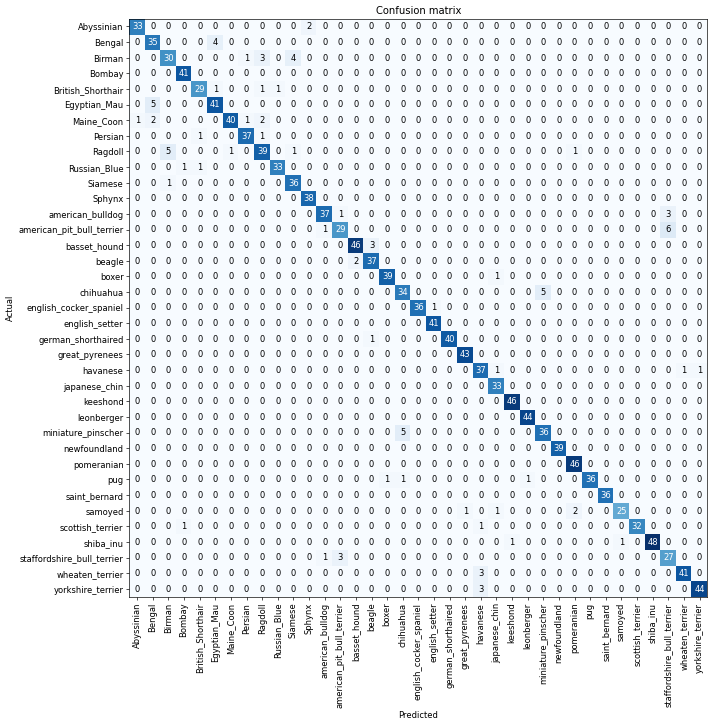

In [12]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [15]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Ragdoll', 'Birman', 5),
 ('chihuahua', 'miniature_pinscher', 5),
 ('miniature_pinscher', 'chihuahua', 5)]

## Learning Rate Finder

In [17]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.933289,9.282301,0.845061,01:11


epoch,train_loss,valid_loss,error_rate,time
0,3.793525,2.390672,0.707713,01:15


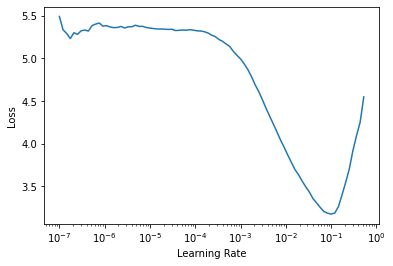

In [18]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In [21]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 3.02e-03


In [23]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.312521,0.338697,0.106901,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.564923,0.334510,0.100135,01:13
1,0.338694,0.228339,0.074425,01:12


## Transfer Learning

In [24]:
learn.fine_tune??

In [28]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
#doing it by hand
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.143124,0.309881,0.098782,01:08
1,0.537993,0.221279,0.073072,01:09
2,0.332365,0.191808,0.062923,01:09


In [29]:
learn.unfreeze()

SuggestedLRs(lr_min=1.737800812406931e-06, lr_steep=1.3182567499825382e-06)

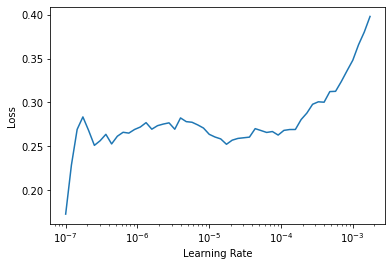

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.251961,0.183225,0.060217,01:14
1,0.243689,0.173300,0.058187,01:14
2,0.215517,0.171965,0.058863,01:13
3,0.209588,0.172690,0.056834,01:14
4,0.201591,0.170895,0.057510,01:14
5,0.200233,0.168561,0.056157,01:14


## Discriminative Learning Rates

In [36]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.214479,0.362006,0.119080,01:10
1,0.566407,0.230928,0.082544,01:10
2,0.342667,0.207684,0.073072,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.275071,0.196490,0.068336,01:14
1,0.256756,0.189676,0.062246,01:14
2,0.249324,0.178804,0.061570,01:14
3,0.234668,0.175350,0.059540,01:14
4,0.205959,0.172277,0.057510,01:12
5,0.176675,0.178310,0.058863,01:13
6,0.157527,0.171088,0.056834,01:13
7,0.155876,0.167980,0.055480,01:13
8,0.148004,0.168425,0.052097,01:13
9,0.156186,0.169090,0.055480,01:13


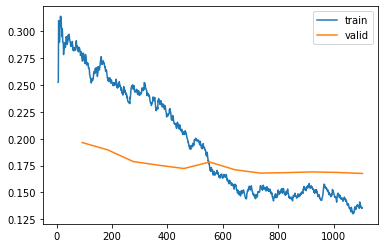

In [37]:
learn.recorder.plot_loss()